## Aperture photometry
This notebook provides code to perform aperture photometry on a sequence of images where the target star is not shifting by more than ~50 or 100 pixels. It allows you to repeat measurements without going in by hand and redoing everything.


Lab 3 detailed how to do simple aperture photometry. I highly recommend going through Lab 3 before this so that you understand what is going on here.

We are going to use Group 3's observations of SW Lac for this exercise.

### Identifying the star of interest.
First we need to identify which star is SW Lac. Begin by opening up the source in simbad. Look at the "aladin lite" view of the source. Try to identify features like triangles and visual binaries (stars that appear to be close together) and try and pinpoint which star is SW Lac. *Usually*, the star of interest will be near the center of the image.

![](ap_photometry_resources/SW_Lac_simbad.png)

<IPython.core.display.Javascript object>


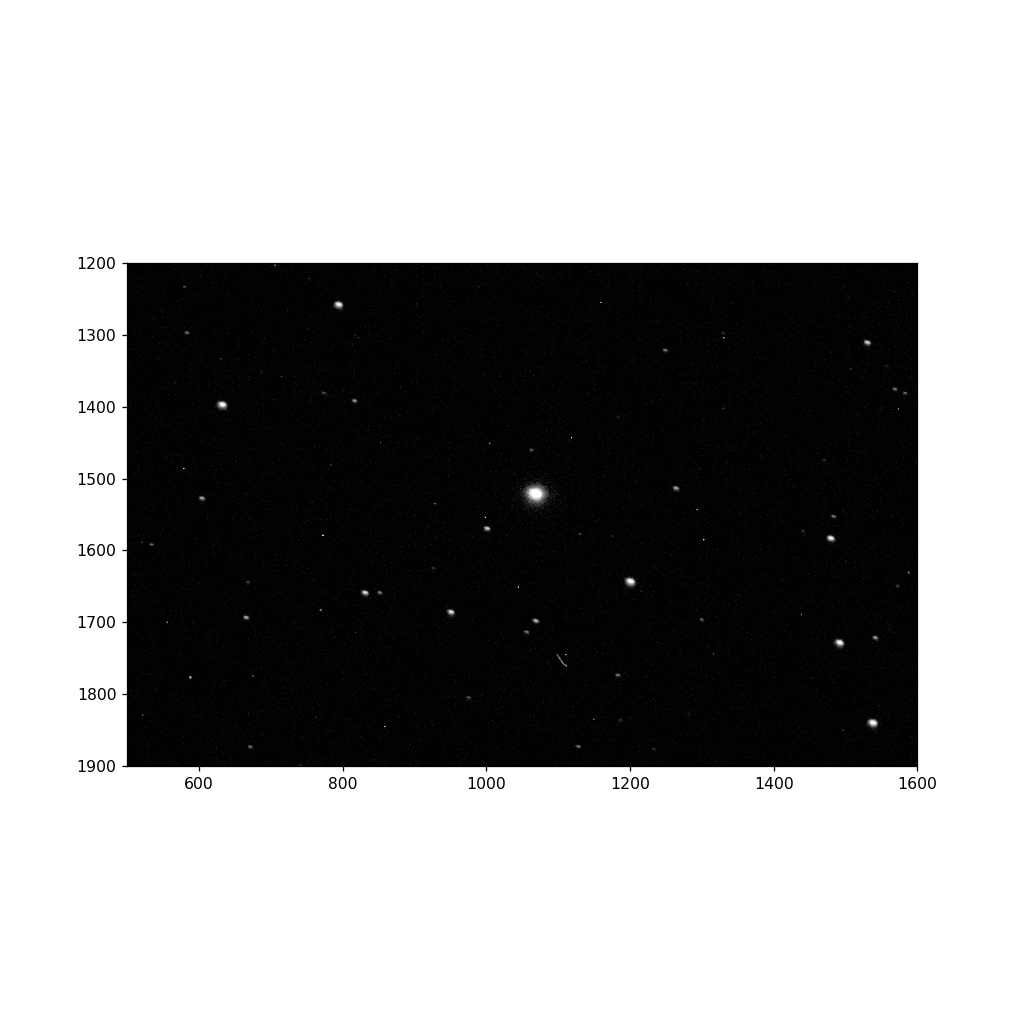

(1900.0, 1200.0)

In [1]:
# Now lets pull up the image in python:
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib notebook
%matplotlib notebook


hdulist = fits.open('ap_photometry_resources/elp0m411-kb92-20210708-0028-e91.fits.fz') # im 1
#hdulist = fits.open('ap_photometry_resources/elp0m411-kb92-20210708-0038-e91.fits.fz') # im 2
im = hdulist['SCI'].data

plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 30
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(np.rot90(display_image, k=-1), norm=LogNorm(vmin=min_clip, vmax=5000), cmap='Greys_r')
plt.xlim((500, 1600)) # zoom in.
plt.ylim((1900, 1200)) # zoom in.

Its plainly clear that the bright star in the image above is SW Lac. Now we are going to use a python package called photutils to find all the stars in our image.

In [2]:
from photutils import DAOStarFinder


uncertainty_im = hdulist['ERR'].data  # this is the uncertainty image.

minimum_pixel_size_of_stars = 10  # only finds stars with a pixel width exceeding 10 pixels. SW Lac has a width of like 40 pixels in the image.
minimum_signal_to_noise = 10  # only finds stars with a minimum signal to noise (per pixel) of 10.

signal_to_noise_image = im/uncertainty_im

daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.

Now we can go ahead and redisplay the image with the stars that daofind found, marked with red crosses.


<IPython.core.display.Javascript object>


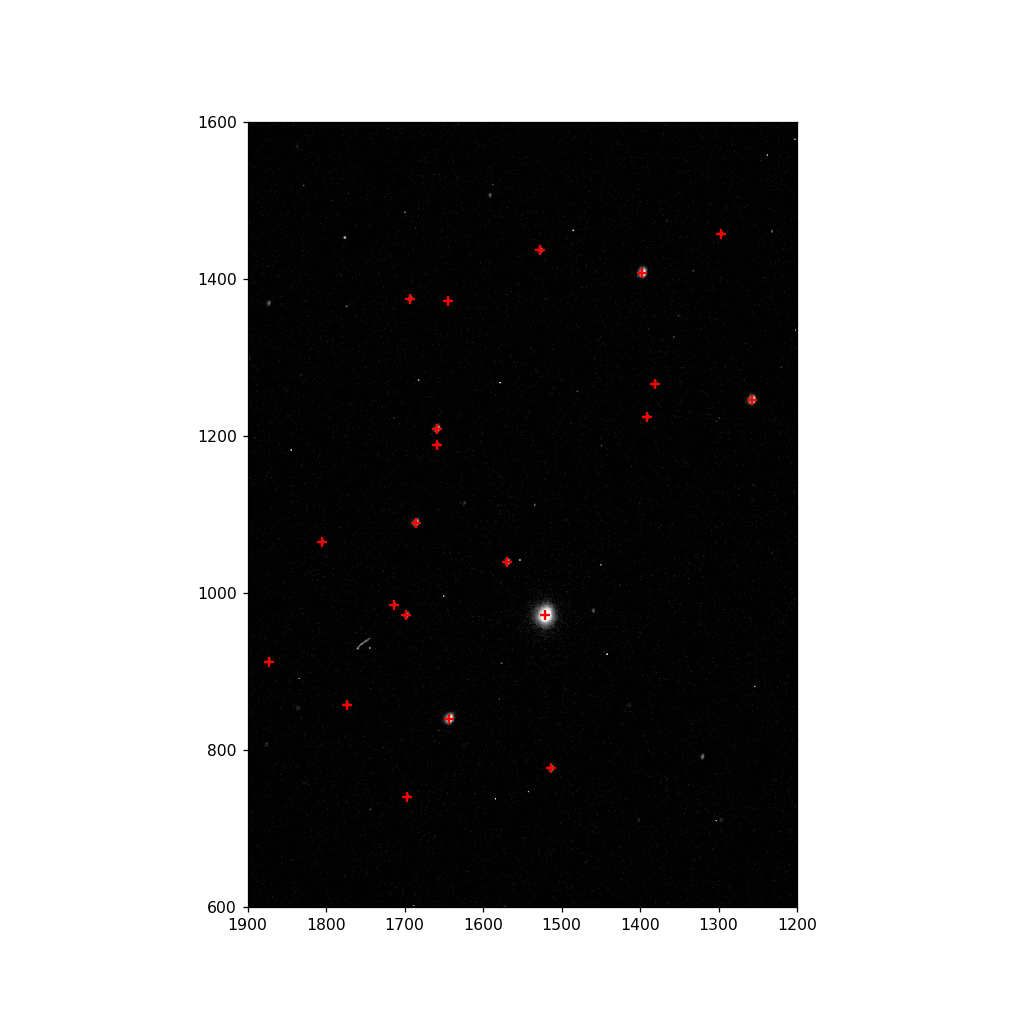

(1900.0, 1200.0)

In [3]:
plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 30
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(display_image, norm=LogNorm(vmin=min_clip, vmax=5000), cmap='Greys_r')
plt.scatter(all_sources['xcentroid'], all_sources['ycentroid'], marker='+', color='r')
plt.ylim((600, 1600)) # zoom in.
plt.xlim((1900, 1200)) # zoom in.

Now we want to mock up some code to find SW Lac in any image that we feed, where SW Lac is at least in the same ~400 pixel region of the sky. 
In pseudo code we are going to:
1. Select all stars in the y,x region with x coordinate 1200 to 1900, and y coordinate 600 to 1600 (the image above).
2. Perform aperture photometry on those stars.
3. SW Lac is going to always be the brightest star in that region, so take that table of flux values and get me the row with the largest flux. That must be SW Lac.
Done!

There are going to be functions here that you have never seen before. Like np.logical_and. Please look up the documentation for them! E.g., https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html

In [4]:
x_limits = (1200, 1900)
y_limits = (600, 1600)

sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

sources = all_sources[sources_that_are_in_our_box]

In [5]:
# sanity check:
# we should have only 9 sources in this table. The image above only has 9 sources. Lets check that:
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
 68 1696.4950542292177 ... 1.4743481967836094  -0.4215001573888687
 74 1513.5315952156795 ...  4.216014818037912  -1.5622553215577082
 78 1642.9572075010644 ...  21.65646197568146   -3.338968768079617
 80 1773.7528922734182 ... 2.1524183735775613  -0.8323167265894694
 86 1873.0457260227215 ...   2.20979262359342  -0.8608787988566179
 90 1520.6772492632265 ...  61.67503465916284   -4.475273505549507
 91  1697.929252251768 ...  5.188114592512182  -1.7875238999998877
 93 1713.7835433023845 ...  2.138468134315485   -0.825256957859143
 98 1569.5507527414497 ...  6.598322058829357   -2.048583773233585
101  1805.109704910611 ... 1.4476901614358753  -0.4016890573164481
105  1685.698585501613 ...   9.18367588859964  -2.4075413703774164
113  1658.963496198671 ...  2.356789140682417  -0.9308018210387254
116 1658.8232643727347 ...   8.92106694572162   -2.37604199606

OK so everything looks good! Ignore the flux and mag columns. We are going to compute those ourselves.

In [6]:
from photutils import CircularAperture
# in the lab, you used a square aperture. Circular is slightly better.
# SW Lac is bright, so the light is spread out wide, so we are going to use a circular aperture of 30. I arrived
# at the value of 30 by just zooming into SW Lac in the image above. We want to catch ALL of the light coming from
# the star.

positions = [(s['xcentroid'], s['ycentroid']) for s in sources] # make a list of (x, y) tuple positions
# yes this time you should really use x,y  , not y,x!!! Amazing I know. Something intuitive for once!
print(positions)

[(1696.4950542292177, 740.5998679635449), (1513.5315952156795, 776.4255087069043), (1642.9572075010644, 839.7079392957996), (1773.7528922734182, 857.6010817275064), (1873.0457260227215, 912.5089359284235), (1520.6772492632265, 971.2919896940806), (1697.929252251768, 971.6484073231329), (1713.7835433023845, 984.2831016623213), (1569.5507527414497, 1039.3648597497413), (1805.109704910611, 1065.099265526174), (1685.698585501613, 1089.6213475689726), (1658.963496198671, 1188.974103623388), (1658.8232643727347, 1209.2020585958762), (1391.806048213897, 1224.0730628556369), (1257.865776478213, 1246.0250767479683), (1381.3059327498722, 1266.6672317430591), (1644.9142948030428, 1372.3219867283788), (1693.2902238371971, 1374.9845835593294), (1397.0179752969034, 1408.0356072605482), (1527.432126161858, 1436.5452095851858), (1297.151656738561, 1457.4543246507221)]


In [7]:
from photutils.aperture import aperture_photometry

aperture = CircularAperture(positions, r=30.)
phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id      xcenter            ycenter       aperture_sum  aperture_sum_err 
           pix                pix                                        
--- ------------------ ------------------ ------------ ------------------
  1 1696.4950542292177  740.5998679635449    28912.326  827.5895530945893
  2 1513.5315952156795  776.4255087069043    34790.752  834.3242133277737
  3 1642.9572075010644  839.7079392957996    191276.19  923.9793818310136
  4 1773.7528922734182  857.6010817275064     28888.48  823.8922355486978
  5 1873.0457260227215  912.5089359284235    26433.309  818.7788242990764
  6 1520.6772492632265  971.2919896940806      3037146 2221.3471507819168
  7  1697.929252251768  971.6484073231329      43550.3  834.7332851116258
  8 1713.7835433023845  984.2831016623213    42296.359  833.2050329396162
  9 1569.5507527414497 1039.3648597497413    49692.533  852.3012712123948
 10  1805.109704910611  1065.099265526174    26230.129  829.8999797410104
 11  1685.698585501613 1089.6213475689

In [8]:
phot_table.sort('aperture_sum', reverse=True)
print(phot_table)
print('note that the square of the aperture_sum_err column is within about a factor of two of aperture_sum itself.')

 id      xcenter            ycenter       aperture_sum  aperture_sum_err 
           pix                pix                                        
--- ------------------ ------------------ ------------ ------------------
  6 1520.6772492632265  971.2919896940806      3037146 2221.3471507819168
  3 1642.9572075010644  839.7079392957996    191276.19  923.9793818310136
 19 1397.0179752969034 1408.0356072605482     137177.5  888.0154429532056
 15  1257.865776478213 1246.0250767479683     101237.1  870.3086996749386
 13 1658.8232643727347 1209.2020585958762    59065.105  841.1161602834355
 11  1685.698585501613 1089.6213475689726    58940.448  837.0549156362293
 12  1658.963496198671  1188.974103623388    58913.659  842.8034464575616
  9 1569.5507527414497 1039.3648597497413    49692.533  852.3012712123948
  7  1697.929252251768  971.6484073231329      43550.3  834.7332851116258
  8 1713.7835433023845  984.2831016623213    42296.359  833.2050329396162
 20  1527.432126161858 1436.5452095851

#### Look at the top most column. The aperture_sum is 3 million! Compared to the next brightest star, which onnly has 191,000 . So the 3 million star must be the brightest. The brightest star in the image is SW Lac, and so we have found a reliable way to find SW Lac. Just take the star (in our little sub region) that is the brightest.


Ok, now we are going to compute the flux of our star relative to the 9 other brightest stars that we saw in the image. This will give us a roughly constant set point. Normally, you would want to do this "anchoring" with a set of standard stars in the field (instead of just 9 bright nearby stars that I see). I encourage you to do that. It will improve your results.

Anchoring the flux to a set of stars (the same within each image!) will cause our fluxes/exposure_time to (hopefully) be calibrated. Meaning any variation that we see is just due to variations in SW Lac.

We are going to anchor relative to the average flux of those nine stars.

In [9]:
n = 9 # number of anchoring stars

sw_lac_anchored_flux = phot_table['aperture_sum'][0] - np.average(phot_table['aperture_sum'][1:n+1])
sw_lac_anchored_flux_error = np.sqrt(phot_table['aperture_sum_err'][0]**2 + np.sum(phot_table['aperture_sum'][1:n+1]**2))/n**2


Now, as a final step, lets convert to magnitudes. For this, remember we just take $-2.5\cdot \log_{10}(\frac{\rm flux- flux\_anchor}{\rm exposure time})$

In lab 3, flux_anchor was the sky. Here we have used the brightnesses of nearby stars. This is generally more reliable. And again, using standard stars is better.



In [10]:
exposure_time = hdulist['SCI'].header['EXPTIME'] # we will need this later

sw_lac_magnitude = -2.5*np.log10(sw_lac_anchored_flux/exposure_time)
print(sw_lac_magnitude)

-11.17320966510054


Now for the error in the magnitude, you will remember this from Lab 3 :)

In [11]:
def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

sw_lac_magnitude, sw_lac_magnitude_error = inst_mag(sw_lac_anchored_flux, sw_lac_anchored_flux_error, exposure_time)

print(f'Our (instrumental) magnitude measurement is {round(sw_lac_magnitude, 3)} +- {round(sw_lac_magnitude_error, 4)}')

Our (instrumental) magnitude measurement is -11.173 +- 0.0013


### Last part: Putting it all together in functions, then running it on multiple images.

I am going to copy and paste all the above code into functions, then re-run the analysis using those functions, on that first image. I want to verify that I get the same answer. This is testing my code to make sure that I have not made any errors.

Then I am going to run my aperture photometry code on two of the images in the sequence.

In [12]:
from astropy.time import Time
from astropy.table import Table
from glob import glob

def load_image(filepath):
    hdulist = fits.open(filepath)
    mid_image_time = Time(hdulist['sci'].header['date-obs'])
    return hdulist['SCI'].data.astype(float), hdulist['ERR'].data.astype(float), hdulist['SCI'].header['EXPTIME'], mid_image_time

def find_stars(im, uncertainty_im, minimum_pixel_size_of_stars=10, minimum_signal_to_noise=10):
    signal_to_noise_image = im/uncertainty_im

    daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
    all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.
    return all_sources

def restrict_sources_to_within_box(all_sources, x_limits=(1200, 1900), y_limits=(600, 1600)):
    sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
    sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

    sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

    sources = all_sources[sources_that_are_in_our_box]
    return sources

def ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=30.0):
    positions = [(s['xcentroid'], s['ycentroid']) for s in sources]
    aperture = CircularAperture(positions, r=aperture_pixel_radius)
    phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
    phot_table.sort('aperture_sum', reverse=True)
    return phot_table


def relative_flux(phot_table, num_anchoring_stars=9):
    n = num_anchoring_stars
    phot_table.sort('aperture_sum', reverse=True)
    sw_lac_anchored_flux = phot_table['aperture_sum'][0] - np.average(phot_table['aperture_sum'][1:n+1])
    sw_lac_anchored_flux_error = np.sqrt(phot_table['aperture_sum_err'][0]**2 + np.sum(phot_table['aperture_sum'][1:n+1]**2))/n**2
    return sw_lac_anchored_flux, sw_lac_anchored_flux_error


def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

def jd_to_hour(time_jd):
    return (time_jd-int(time_jd))*24%(0.3207204*24)


def fixed_time(time_jd, min_time):
    return (time_jd-min_time)*24 % (0.3207204*24)

# Putting all the above functions together:
def process_image(filepath_to_e91_file):
    im, uncertainty_im, exposure_time, observation_time = load_image(filepath_to_e91_file)
    all_sources = find_stars(im, uncertainty_im)
    sources = restrict_sources_to_within_box(all_sources, x_limits=(1200, 1900), y_limits=(600, 1600))
    phot_table = ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=30.0)
    flux, flux_error = relative_flux(phot_table, num_anchoring_stars=9)
    mag, mag_error = inst_mag(flux, flux_error, exposure_time)
    return mag, mag_error, observation_time, flux, flux_error

In [17]:
# grabbing all the e91 images:
all_images = glob('ap_photometry_resources/*e91*')
#print(type(all_images[0]))
#return
#all_images = glob('/home/gmbrandt/Documents/misc/data/SW_Lac/*e91*')

# processing all the images
output = {'mag': [], 'mag_error': [], 'time': [], 'flux':[], 'flux_error':[]}
for fpath in all_images:
    '''
    if "0709" in fpath:
        continue
    '''
    mag, mag_error, observation_time, flux, flux_error = process_image(fpath)
    output['mag'].append(mag)
    output['mag_error'].append(mag_error)
    output['time'].append(observation_time)
    output['flux'].append(flux)
    output['flux_error'].append(flux_error)

    
sw_lac_results = Table(output)
    

<IPython.core.display.Javascript object>


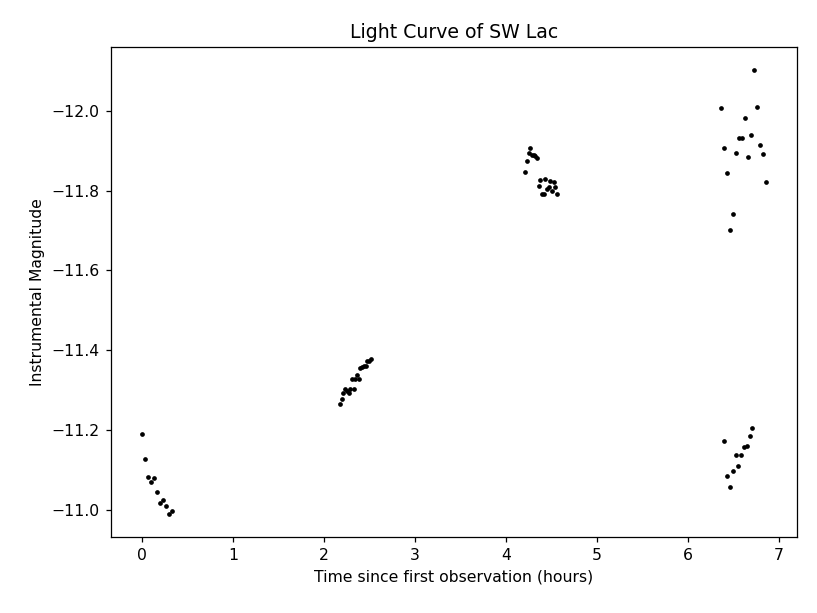

(77,)
(77,)


In [18]:
# plotting all the results

plt.figure()
#print((sw_lac_results['time'].jd[0]-int(sw_lac_results['time'].jd[0]))*24%8)
#plt.errorbar((sw_lac_results['time'].jd - np.min(sw_lac_results['time'].jd))*24, sw_lac_results['mag'], 
#           yerr=sw_lac_results['mag_error'], ls='none', marker='o', markersize=2, color='k')
print(sw_lac_results['time'].jd.shape)
print(sw_lac_results['mag'].shape)
times = []
for jdtime in sw_lac_results['time'].jd:
    times.append(fixed_time(jdtime, np.min(sw_lac_results['time'].jd)))


plt.errorbar(np.array(times), sw_lac_results['mag'], yerr=sw_lac_results['mag_error'], ls='none', marker='o', markersize=2, color='k')

plt.xlabel('Time since first observation (hours)')
plt.ylabel('Instrumental Magnitude')
plt.title('Light Curve of SW Lac')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


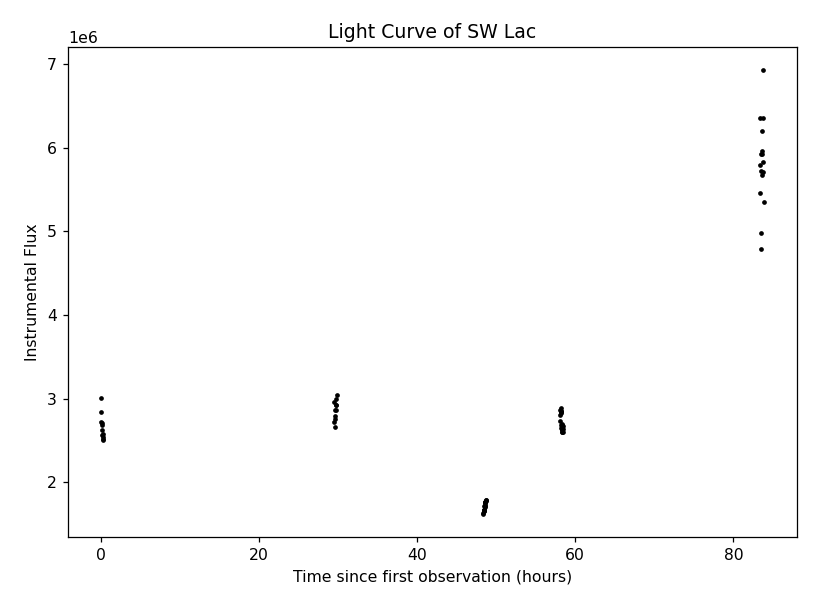

In [19]:
# plotting all the results. Optional plot of the flux.

plt.figure()
plt.errorbar((sw_lac_results['time'].jd - np.min(sw_lac_results['time'].jd))*24, sw_lac_results['flux'], 
             yerr=sw_lac_results['flux_error'], ls='none', marker='o', markersize=2, color='k')
plt.xlabel('Time since first observation (hours)')
plt.ylabel('Instrumental Flux')
plt.title('Light Curve of SW Lac')
plt.tight_layout()
plt.show()

Voila! We now have two sets of magnitudes (and fluxes). 

If this were a standard star, we would want these two mags be roughly equal within the errors. By that I mean that the difference in their two magnitude values is less than mag_err. Ideally, those two datapoints should be within the scatter of one another. This means that we have done things correctly (if this was a standard star).

But SW Lac is a variable star.

And these magnitude differences are many times the formal error. This could be due to variability in SW Lac, or it could be due to the fact that I anchored relative to other stars that could be varying themselves (i.e., it could be due to my "data analysis pipeline" being incorrect!). I leave that to you to find out :).

Hint: Look up a light curve of SW Lac. How much (in magnitude) should it be changing over a period of 0.3 hours?

### Disclaimer: This code is not bullet proof. It may require some tweaking for your star/stars. But it is a starting point!!